<a href="https://colab.research.google.com/github/wandieinnocents/Sales_analysis_linearRegression-XGboost-Randomforest/blob/main/sales_analysis_linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,  LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# read the dataset 
store_sales = pd.read_csv("/content/drive/MyDrive/research/project2/dataset/train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check for null values

In [4]:
# check the dataset to know it 
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


There are no null values in the dataset

Since am looking at getting the overal sales for all the stores , i drop the item , and storeID

In [5]:
# drop the store and item
store_sales = store_sales.drop(['store','item'], axis=1)
store_sales

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
...,...,...
912995,2017-12-27,63
912996,2017-12-28,59
912997,2017-12-29,74
912998,2017-12-30,62


In [6]:
# get infor of the data
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


##Converting date from object datatype to datetime datatype 

The date is of object datatype, which is not correct , i convert it to datetime datatype

In [7]:
# converting date
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


#WE WANT TO TRAIN THE MODEL TO PREDICT SALES IN NEXT MONTH INSTEAD OF DAY
- I convert the date to the period of a month
- Then i add/summ-up all the items sold in each month


In [9]:
# convert date to period of month and sum all items sold in each month
# dt.to_period allows for converting a date to a specific interval.
store_sales['date'] = store_sales['date'].dt.to_period("M")
# montly sales 
monthly_sales = store_sales.groupby('date').sum().reset_index()

Converting the date column to timestamp datatype

In [10]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [11]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Vizaualizing the montly sales of items

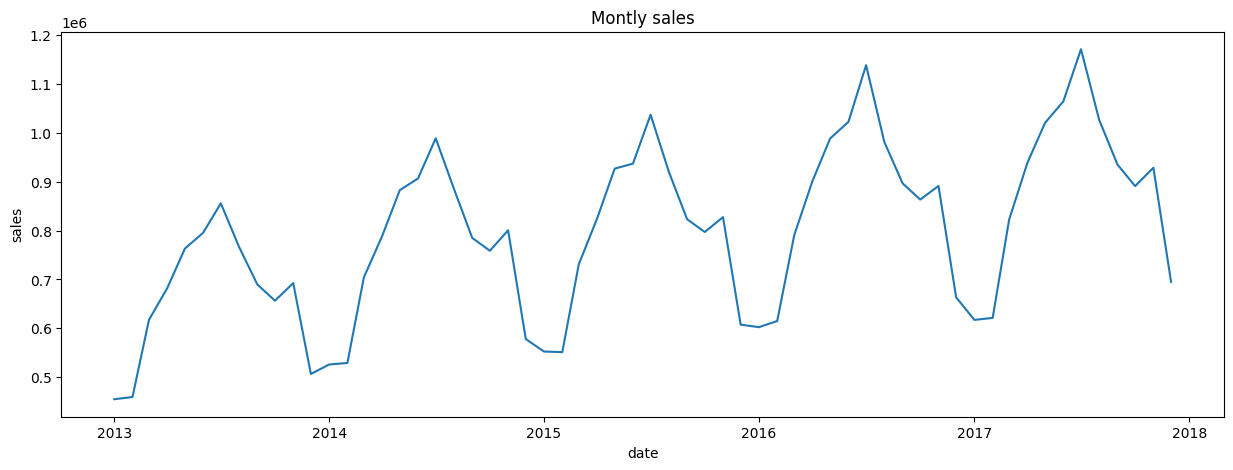

In [12]:
plt.figure(figsize=(15,5))
# (y,x)
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title("Montly sales")
plt.show()

SALES DIFFERENCE 
Get the difference on the sales column, to make the sales data stationery, this shows the sales that were obtained between months, which can be showing incerease or decrease in the number of sales

In [13]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


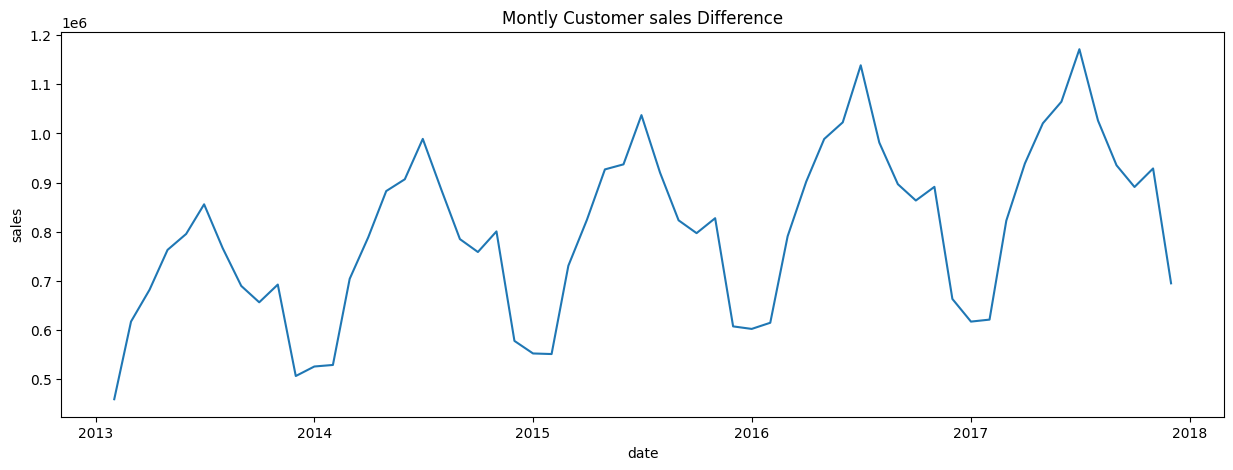

In [14]:
plt.figure(figsize=(15,5))
# (y,x)
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title("Montly Customer sales Difference")
plt.show()

#PREDICTING SALES IN THE NEXT MONTH
- Here i  train the model to predict the sale of items in next month
- i do so by looking at specific number of items in the previous month
- i prepare supervised dataset to handle the task


I drop off the date and sale  , since i will be working with stationery sales data and use it to train the machine learning model.

In [15]:
# dropping of sales and date
supervised_data = monthly_sales.drop(['date','sales'], axis=1)

Prepare the supervised data so that the previous 12 months sales, will act as the input features , and the next 12 months sales, will be the output for the supervised learning model

In [16]:
for i in range(1,13):
  col_name = 'month_' + str(i) 
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data to training and testing data

In [17]:
# train data for previous 12 months
train_data = supervised_data[:-12]

# test data for the next 12 months
test_data = supervised_data[-12:]
print("Train data shape", train_data.shape)
print("test_data shape", test_data.shape)

Train data shape (35, 13)
test_data shape (12, 13)


Use the MinMaxscaler to scale the feature values to restrict them to values of -1 and 1


In [18]:
scaler =  MinMaxScaler(feature_range=(-1,1)) 
# fit the train data to the scaler
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In supervised data , the first column corresponds to the output and the remaining columns act as input features


In [19]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel() 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (35, 12)
y_train shape (35,)
x_test shape (12, 12)
y_test shape (12,)


Make prediction dataframe to merge the predicted sale prices of all the trained algorithms

In [20]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df =  pd.DataFrame(sales_dates)

 show sales for last 13 months

In [21]:
# show sales for last 13 months
actual_sales = monthly_sales ['sales'][ -13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


LINEAR REGRESSION 

it is used to find a linear relationship between a set of input variables and the output variables . 
Next is to create the linear regression model , and the predicted output

In [22]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [23]:
# transform the predicted functions to the original scale.
# create linear regression prediction and reshape it
lr_pre = lr_pre.reshape(-1,1)
# matrix which contains the input features of test data and predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [24]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  # firt index of iterator
  result_list.append(lr_pre_test_set[index][0] + actual_sales[index])

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

Compare the actual and predicted sale values , to see the deviations and differences , and learn from the data.

In [25]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [26]:
# mean squared error 
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
# mean absolute error
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

lr_r2  = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

# print the errors
print("Linear regression MSE", lr_mse)
print("Linear regression MAE", lr_mae)
print("Linear regression R2 ", lr_r2)


Linear regression MSE 16221.272385416869
Linear regression MAE 12433.184266490736
Linear regression R2  0.9906152516380969


Lets vizualize the predictions against actual sales

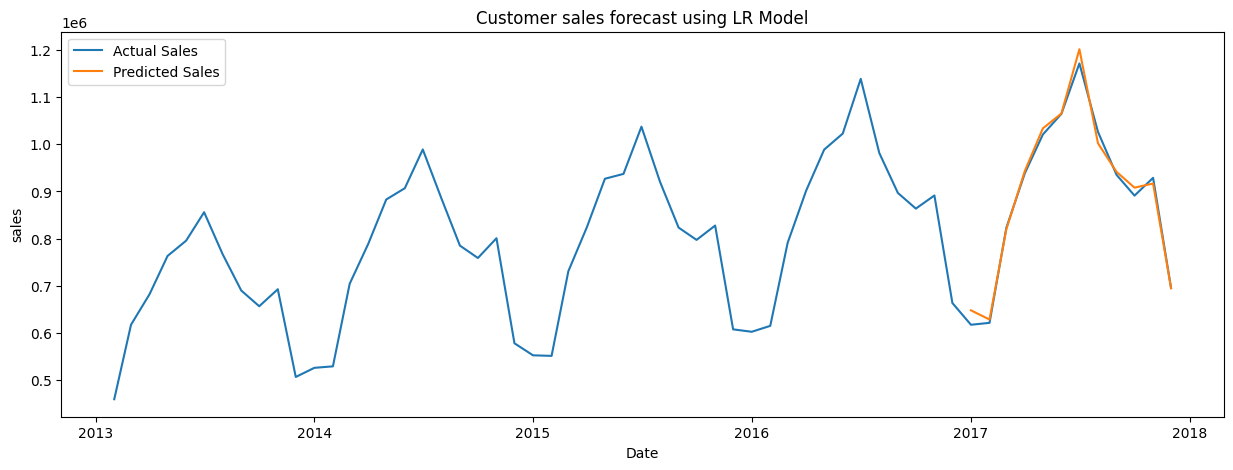

In [27]:
plt.figure(figsize=(15,5))
# actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])

# predicted sales
# sales predicted = Linear Prediction
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.xlabel('Date')
plt.ylabel('sales')
plt.title("Customer sales forecast using LR Model")
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()